In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import Pipeline
from sklearn import metrics
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, roc_auc_score

import warnings
import os
import sys
if not sys.warnoptions:
    warnings.simplefilter("ignore")
    os.environ["PYTHONWARNINGS"] = "ignore"

np.random.seed(42)

In [2]:
from tabulate import tabulate

def show_scores(clf, X, y):
    y_pred = clf.predict(X)
    y_pred_prob = clf.predict_proba(X)
    print(tabulate(confusion_matrix(y, y_pred), headers=['Predicted 0', 'Predicted 1'], tablefmt='orgtbl'))
    print()
    print(f'accuracy:              {round(accuracy_score(y, y_pred), 4)}')
    print(f'precision:             {round(precision_score(y, y_pred), 4)}')
    print(f'recall:                {round(recall_score(y, y_pred), 4)}')
    print(f'f1:                    {round(f1_score(y, y_pred), 4)}')
    print(f'roc_auc:               {round(roc_auc_score(y, y_pred), 4)}')
    print(f'roc_auc_pred_prob:     {round(roc_auc_score(y, y_pred_prob[:, 1]), 4)}')

### Ładowanie zbiorów danych, pierwszy model


In [3]:
X_train = pd.read_csv("../preprocessed_data/X_train.csv")
y_train = pd.read_csv("../preprocessed_data/y_train.csv")

X_val  = pd.read_csv("../preprocessed_data/X_val.csv")
y_val  = pd.read_csv("../preprocessed_data/y_val.csv")

In [4]:
log_reg = LogisticRegression(random_state=42, class_weight='balanced').fit(X_train, y_train)

In [5]:
show_scores(log_reg, X_train, y_train)
show_scores(log_reg, X_val, y_val)


|   Predicted 0 |   Predicted 1 |
|---------------+---------------|
|         34512 |         10283 |
|          2415 |          3878 |

accuracy:              0.7514
precision:             0.2739
recall:                0.6162
f1:                    0.3792
roc_auc:               0.6933
roc_auc_pred_prob:     0.7643
|   Predicted 0 |   Predicted 1 |
|---------------+---------------|
|         14685 |          4527 |
|          1044 |          1639 |

accuracy:              0.7456
precision:             0.2658
recall:                0.6109
f1:                    0.3704
roc_auc:               0.6876
roc_auc_pred_prob:     0.7581


### Regularyzacja


In [6]:
clf = LogisticRegression(random_state=42, class_weight='balanced', solver='liblinear')

parameters = dict(C=np.logspace(-6, 2, 20), penalty=['l1', 'l2'])
reg_search = GridSearchCV(clf, cv=3, scoring='balanced_accuracy', return_train_score=True, param_grid=parameters, n_jobs=-1).fit(X_train, y_train)

In [7]:
res = pd.DataFrame(reg_search.cv_results_).sort_values("mean_test_score", ascending=False)
for mean_score, params in zip(res["mean_test_score"], res["params"]):
    print(round(mean_score, 4), "   ", params)

0.6904     {'C': 0.2976351441631313, 'penalty': 'l1'}
0.6901     {'C': 0.11288378916846883, 'penalty': 'l2'}
0.6901     {'C': 0.2976351441631313, 'penalty': 'l2'}
0.6898     {'C': 0.04281332398719396, 'penalty': 'l2'}
0.6898     {'C': 0.7847599703514607, 'penalty': 'l1'}
0.6896     {'C': 5.455594781168514, 'penalty': 'l2'}
0.6896     {'C': 2.06913808111479, 'penalty': 'l1'}
0.6896     {'C': 2.06913808111479, 'penalty': 'l2'}
0.6895     {'C': 14.384498882876601, 'penalty': 'l2'}
0.6895     {'C': 37.92690190732246, 'penalty': 'l1'}
0.6894     {'C': 100.0, 'penalty': 'l2'}
0.6894     {'C': 37.92690190732246, 'penalty': 'l2'}
0.6894     {'C': 14.384498882876601, 'penalty': 'l1'}
0.6894     {'C': 100.0, 'penalty': 'l1'}
0.6894     {'C': 5.455594781168514, 'penalty': 'l1'}
0.6892     {'C': 0.7847599703514607, 'penalty': 'l2'}
0.6891     {'C': 0.01623776739188721, 'penalty': 'l2'}
0.6887     {'C': 0.11288378916846883, 'penalty': 'l1'}
0.6876     {'C': 0.00615848211066026, 'penalty': 'l2'}
0.6

In [8]:
show_scores(reg_search.best_estimator_, X_train, y_train)
show_scores(reg_search.best_estimator_, X_val, y_val)

|   Predicted 0 |   Predicted 1 |
|---------------+---------------|
|         34575 |         10220 |
|          2425 |          3868 |

accuracy:              0.7525
precision:             0.2746
recall:                0.6147
f1:                    0.3796
roc_auc:               0.6933
roc_auc_pred_prob:     0.7641
|   Predicted 0 |   Predicted 1 |
|---------------+---------------|
|         14699 |          4513 |
|          1052 |          1631 |

accuracy:              0.7458
precision:             0.2655
recall:                0.6079
f1:                    0.3695
roc_auc:               0.6865
roc_auc_pred_prob:     0.7578


### Wizualizacje

In [9]:
def gini_roc(y_test, y_pred_proba, tytul):

    fpr, tpr, _ = metrics.roc_curve(y_test,  y_pred_proba)

    plt.plot(fpr,tpr)
    plt.title(tytul)
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.show()

    roc_auc = metrics.auc(fpr, tpr)
    gini = (2 * roc_auc) - 1

    return gini

def gini_train_val(model, X_train, y_train, X_val, y_val):

    y_pred_proba = model.predict_proba(X_train)[::,1]
    gini_train = gini_roc(y_train, y_pred_proba, "ROC Curve for Training Sample")
    print("gini_train: %.4f" % gini_train)

    y_pred_proba = model.predict_proba(X_val)[::,1]
    gini_val = gini_roc(y_val, y_pred_proba, "Roc Curve for Validation Sample")
    print("gini_val: %.4f" % gini_val)

    return

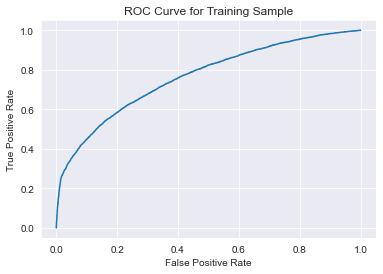

gini_train: 0.5282


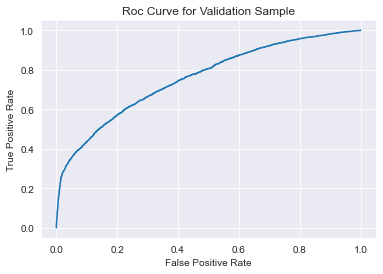

gini_val: 0.5157


In [10]:
gini_train_val(reg_search.best_estimator_, X_train, y_train, X_val, y_val)

### Model z wielomianowymi cechami

In [11]:
model = Pipeline([
    ('poly', PolynomialFeatures(degree=2)),
    ('logreg', LogisticRegression(random_state=42))
]).fit(X_train, y_train)

In [12]:
show_scores(model, X_train, y_train)
show_scores(model, X_val, y_val)

|   Predicted 0 |   Predicted 1 |
|---------------+---------------|
|         44456 |           339 |
|          4713 |          1580 |

accuracy:              0.9011
precision:             0.8233
recall:                0.2511
f1:                    0.3848
roc_auc:               0.6218
roc_auc_pred_prob:     0.8084
|   Predicted 0 |   Predicted 1 |
|---------------+---------------|
|         18994 |           218 |
|          2009 |           674 |

accuracy:              0.8983
precision:             0.7556
recall:                0.2512
f1:                    0.3771
roc_auc:               0.6199
roc_auc_pred_prob:     0.7608
